prepare

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import re
import random

In [3]:
# Import series of helper functions for the notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves

In [4]:
# Check GPU

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Read dataset

In [5]:
df_data=pd.read_csv('data_1A.csv')
df_data = df_data.drop(columns=['Unnamed: 0'])
df_data.head(10)

,text,label
0,Tuberculous peritonitis: a study comparing cir...,cardiovascular diseases
1,Clinical and Doppler echocardiographic follow-...,general pathological conditions
2,Pulmonary embolism presenting as exercise-indu...,nervous system diseases
3,Pancreatitis. Pancreatitis is a common but rat...,cardiovascular diseases
4,Xeroderma pigmentosum: review and report of a ...,general pathological conditions
5,Brain abscess associated with congenital pulmo...,general pathological conditions
6,Implication of specific DQB1 alleles in geneti...,general pathological conditions
7,Primary adenocarcinoma of the bladder: favorab...,digestive system diseases
8,Cancer surveillance in ulcerative colitis. Dur...,digestive system diseases
9,Activated protooncogenes in human lung tumors ...,digestive system diseases


encode

In [6]:
#Encoding Categorical to Numeric 

label_encode={"label": {"cardiovascular diseases":0,"general pathological conditions" :1,"nervous system diseases":2,
                       "digestive system diseases":3, "neoplasms":4}}
df_data=df_data.replace(label_encode)

cleansing text

In [7]:
def cleansing(df_data):
    df_clean = df_data.str.lower()
    df_clean = [re.sub(r'[^\w\s]', '', i) for i in df_clean]
    df_clean = [re.sub(r'\s+', ' ', i) for i in df_clean]
    return df_clean

In [8]:
df_data['clean_text'] = cleansing(df_data['text'])
df_data.drop('text', axis=1, inplace=True)
df_data.head(5)

,label,clean_text
0,0,tuberculous peritonitis a study comparing cirr...
1,1,clinical and doppler echocardiographic followu...
2,2,pulmonary embolism presenting as exerciseinduc...
3,0,pancreatitis pancreatitis is a common but rath...
4,1,xeroderma pigmentosum review and report of a c...


Exploratory Data Analysis

In [9]:
# Check unique

unique_sentiments = df_data['label'].unique()
print(unique_sentiments)

[0 1 2 3 4]


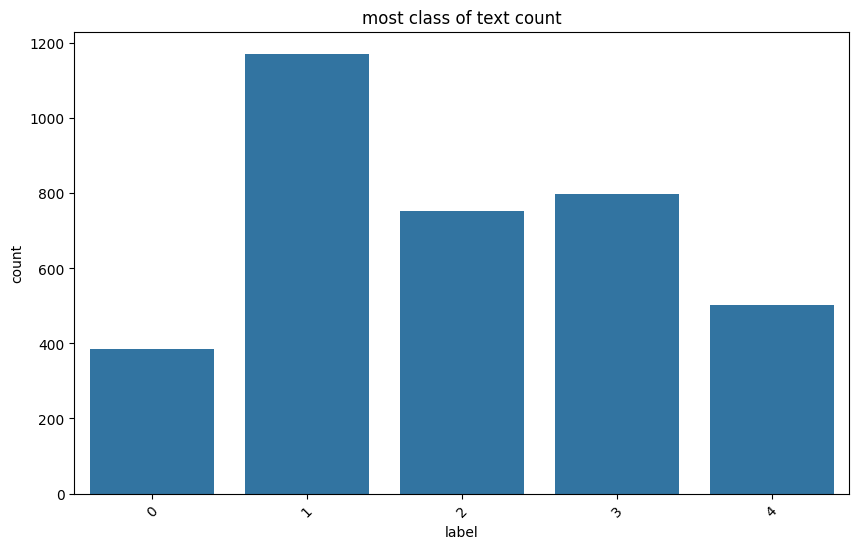

In [10]:
# Check the distribution of classes

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df_data)
plt.xticks(rotation=45)
plt.title('most class of text count')
plt.show()

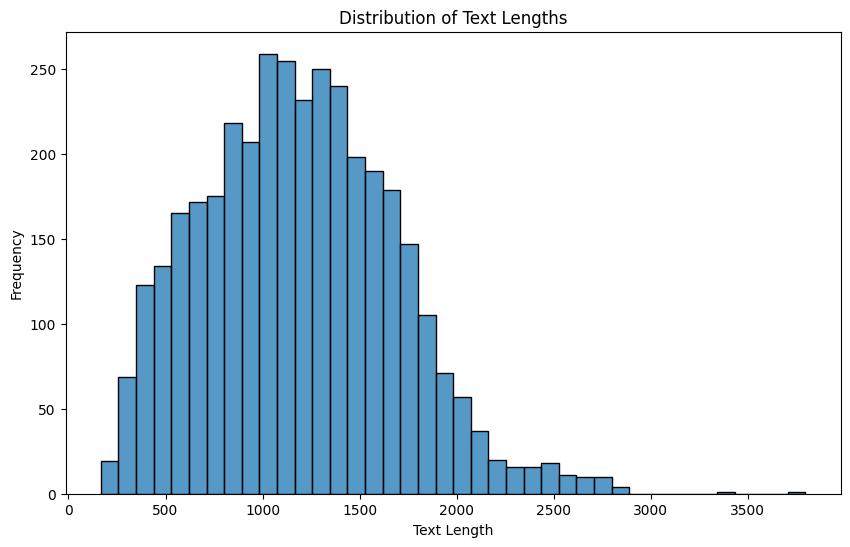

In [11]:
# Check the distribution of text lengths

df_data['text_length'] = df_data['clean_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df_data['text_length'])
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

In [12]:
# visualize some random training examples
# create random indexes not higher than the total number of samples

random_index = random.randint(0, len(df_data) - 3)
for row in df_data[["clean_text", "label"]].iloc[random_index:random_index+3].itertuples():
    _, clean_text, label = row
    sentiment_label = ""
    if label == 0:
        sentiment_label = "(cardiovascular diseases)"
    elif label == 1:
        sentiment_label = "(general pathological conditions)"
    elif label == 2:
        sentiment_label = "(nervous system diseases)"
    elif label == 3:
        sentiment_label = "(digestive system diseases)"
    elif label == 4:
        sentiment_label = "(neoplasms)"
    
    print(f"Target: {label} {sentiment_label}")
    print(f"text:\n{clean_text}\n")
    print("---\n")

Target: 3 (digestive system diseases)
text:
attributes and survival patterns of multiple primary cutaneous malignant melanoma from a series of 1495 patients with primary cutaneous malignant melanoma pcmm 26 patients 173 had multiple primary cutaneous malignant melanoma mpcmm this report describes the attributes and survival patterns in this small but important subgroup of patients with pcmm of 26 patients 23 had two primaries two had three primaries and one had six primaries five patients had synchronous and 21 patients had metachronous mpcmm the median interval between the occurrence of the first and subsequent pcmm in these patients was 193 years the estimated 5year survival rate from the first melanoma was 835 that from the last melanoma was 531 in summary mpcmm is a distinct biologic phenomenon a second or subsequent malignant melanoma should be treated like a primary melanoma 

---

Target: 2 (nervous system diseases)
text:
the effect of abdominal surgery on the serum concentratio

split test

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df_data['clean_text'].to_numpy(),df_data['label'].to_numpy(),
    test_size=0.2,
    random_state=42,
    stratify=df_data['label']
)

In [15]:
# Check the lengths

len(x_train), len(x_test), len(y_train), len(y_test)

(2887, 722, 2887, 722)

In [16]:
# View the sample training sentences and their labels

x_train[:3], y_train[:3]

(array(['polycystic ovary syndrome polycystic ovary syndrome is a disorder of unknown cause characterized by anovulation hyperandrogenism and gonadotropin secretory abnormalities producing oligoovulation or anovulation hyperinsulinemia and insulin resistance are important features of this syndrome because other causes of androgen excess may produce similar clinical and biochemical findings pco remains a diagnosis of exclusion treatment is directed toward relieving symptoms of hyperandrogenemia in order to stimulate ovulation correcting obesity and inducing regular menses to reduce the risk of endometrial cancer ',
        'coronary dynamics and mental arithmetic stress in humans incidence and mechanisms of psychological stressinduced myocardial ischemia were investigated in a population of 63 patients using mental arithmetic fifty subjects group 1 were selected as a consecutive population of ischemic patients with electrocardiographic documentation of ischemia at rest on effort or both

Text vectorization (tokenization)

In [17]:
# Find average number of tokens words in training
round(sum([len(i.split()) for i in x_train])/len(x_train))

178

In [18]:
from tensorflow.keras.layers import TextVectorization

# Setup text vectorization with custom variables
max_vocab_length = 68000 # max number of words in vocabulary
max_length = 50 # max length 

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [19]:
# Fit the text vectorizer to the training text

x_train = np.array(x_train)
text_vectorizer.adapt(x_train)

In [20]:
# Create sample sentence and tokenize it

sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[    1,     7,     1,     5, 18613, 12084,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int64)>

In [21]:
# Choose a random sentence from the training dataset and tokenize it

random_sentence = random.choice(x_train)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
continuous arteriovenous rewarming experimental results and thermodynamic model simulation of treatment for hypothermia we evaluated a technique for treating hypothermia that uses extracorporeal circulation but does not require heparin or pump assistance hypothermia to 295 degrees c was induced in eight anesthetized dogs and thermistors placed in the pulmonary artery liver bladder esophagus rectum muscle and skin four experimental animals were rewarmed by creating a fistula which connected arterial and venous femoral lines to an interposed countercurrent heat exchanger external rewarming was used in four controls bleeding time bt coagulation profile pt ptt tt and cardiac output co were measured during rewarming core temperature t rose significantly faster with cavr 000001 average time to rewarming was 45 min vs 4 hrs in controls haptoglobin platelet fibrinogen and fibrin split product levels were unaffected continuous arteriovenous rewarming cavr improved t co bt and coa

<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[  687,  1502,  3820,   670,    54,     4, 16123,   424,  9902,
            3,    35,    12,  2146,    33,   304,     7,   370,    12,
         1785,  2146,    15,  3788,  1627,  1382,    44,   652,    27,
         1537,   709,    14,  1707,  3758,  2146,     8,  7155,   950,
          591,    10,   363,     5,   332,  1914,   590,     4, 11954,
         1290,     5,     2,   152,    81]], dtype=int64)>

Creating an Embedding using an Embedding Layer

In [22]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding") 

embedding

In [23]:
# Get a random sentence from training set

random_sentence = random.choice(x_train)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
posterior nuchal cystic hygroma published erratum appears in clin perinatol 1990 dec174viii when cystic hygroma is detected antenatally the prognosis is usually poor and intrauterine or neonatal death are common this seems especially true for turner syndrome the largest etiologic group associated with cystic hygroma and the lethal multiple pterygium syndromes however some fetuses with turner syndrome and also with certain other diagnoses had a good outcome and further study of these conditions is required before more definite prognostic indicators and risk figures will be available increasing numbers of syndromes are being reported in association with fetal cystic hygroma and lymphedema may be a common element in their pathogenesis mild shortlived or otherwise uncomplicated jugular lymphatic obstruction may be a cause of the neck webbing seen in the noonan familial pterygium colli and distichiasislymphedema syndromes with earlier and more widespread fetal ultrasonography

<tf.Tensor: shape=(1, 50, 128), dtype=float32, numpy=
array([[[-0.00586817, -0.02591968,  0.00034708, ...,  0.01580973,
         -0.02715619, -0.00199605],
        [-0.02161232,  0.02966306, -0.00423169, ..., -0.02349964,
          0.01803902, -0.0214098 ],
        [-0.0487933 , -0.04997355, -0.02838928, ...,  0.01764831,
          0.02361304,  0.00879205],
        ...,
        [-0.02950379,  0.0462457 , -0.01789059, ..., -0.02031417,
         -0.0208772 , -0.04833288],
        [-0.0302542 , -0.02328177,  0.00418866, ..., -0.03512411,
         -0.03765611, -0.04305565],
        [ 0.02562609, -0.00211345,  0.04750241, ..., -0.04223474,
          0.04756758,  0.04050508]]], dtype=float32)>

In [24]:
# Check out a single token's embedding

sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.00586817, -0.02591968,  0.00034708, -0.01662426, -0.02487781,
       -0.04828553,  0.04342239,  0.02189166,  0.01202212, -0.02789721,
       -0.03012874, -0.02801366,  0.01889325, -0.04405996, -0.00549662,
        0.03647039, -0.01166261, -0.0360814 ,  0.01845229, -0.03441453,
       -0.02967168,  0.03227265,  0.04638631,  0.03928075,  0.04507712,
        0.0072518 ,  0.01310155,  0.0326085 , -0.04715288,  0.01226175,
       -0.00316818, -0.04255771, -0.01596109, -0.02888017, -0.02812392,
        0.04509722, -0.02138457,  0.04217627, -0.02834356, -0.00042029,
       -0.02101803, -0.01116695,  0.01597706, -0.00717663, -0.03511866,
       -0.03892782, -0.04057109,  0.04091299, -0.04718148,  0.00394498,
       -0.01106297,  0.03186288, -0.01075181,  0.04132   ,  0.01249274,
        0.00355781,  0.03060652,  0.04040405,  0.02856727,  0.00825004,
       -0.02697312,  0.03255785, -0.00699491,  0.02835883, -0.02758682,
        0.031242

LSTM Model

In [25]:
# Set random seed and embedding layer
tf.random.set_seed(42)

from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)

# x = layers.LSTM
x = layers.LSTM(64)(x)

# x = layers.Dense
outputs = layers.Dense(5, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs, name="model_LSTM")

In [26]:
# Compile model
model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [27]:
# Get a summary of the model
model.summary()

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 50)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 50, 128)           8704000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 8,753,733
Trainable params: 8,753,733
Non-trainable params: 0
______________________________________________

In [28]:
# Create ModelCheckpoint callback
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "./best_model.LSTM"
model_checkpoint = ModelCheckpoint(checkpoint_path, 
                                   monitor='val_accuracy', 
                                   save_best_only=True, 
                                   mode='max', 
                                   verbose=1)

In [29]:
# Fit model
SAVE_DIR = "./logs"
model_history = model.fit(x_train,
                          y_train,
                          epochs=5,
                          validation_data=(x_test, y_test),
                          callbacks=[create_tensorboard_callback(SAVE_DIR, "LSTM_model"), model_checkpoint])

Saving TensorBoard log files to: ./logs/LSTM_model/20240222-111249
Epoch 1/5
90/91 [============================>.] - ETA: 0s - loss: 1.5534 - accuracy: 0.3205
Epoch 1: val_accuracy improved from -inf to 0.32548, saving model to .\best_model.LSTM


INFO:tensorflow:Assets written to: .\best_model.LSTM\assets


INFO:tensorflow:Assets written to: .\best_model.LSTM\assets


91/91 [==============================] - 11s 62ms/step - loss: 1.5535 - accuracy: 0.3197 - val_loss: 1.5275 - val_accuracy: 0.3255
Epoch 2/5
88/91 [============================>.] - ETA: 0s - loss: 1.2355 - accuracy: 0.4918
Epoch 2: val_accuracy improved from 0.32548 to 0.47230, saving model to .\best_model.LSTM


INFO:tensorflow:Assets written to: .\best_model.LSTM\assets


INFO:tensorflow:Assets written to: .\best_model.LSTM\assets


91/91 [==============================] - 4s 45ms/step - loss: 1.2273 - accuracy: 0.4977 - val_loss: 1.3164 - val_accuracy: 0.4723
Epoch 3/5
88/91 [============================>.] - ETA: 0s - loss: 0.6781 - accuracy: 0.7884
Epoch 3: val_accuracy did not improve from 0.47230
91/91 [==============================] - 1s 14ms/step - loss: 0.6812 - accuracy: 0.7863 - val_loss: 1.4535 - val_accuracy: 0.4460
Epoch 4/5
87/91 [===========================>..] - ETA: 0s - loss: 0.3765 - accuracy: 0.8915
Epoch 4: val_accuracy did not improve from 0.47230
91/91 [==============================] - 1s 13ms/step - loss: 0.3770 - accuracy: 0.8912 - val_loss: 1.6768 - val_accuracy: 0.4460
Epoch 5/5
90/91 [============================>.] - ETA: 0s - loss: 0.2530 - accuracy: 0.9257
Epoch 5: val_accuracy did not improve from 0.47230
91/91 [==============================] - 1s 13ms/step - loss: 0.2537 - accuracy: 0.9255 - val_loss: 1.9352 - val_accuracy: 0.4668


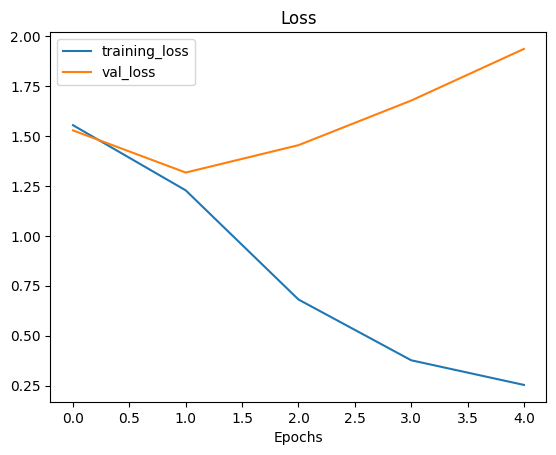

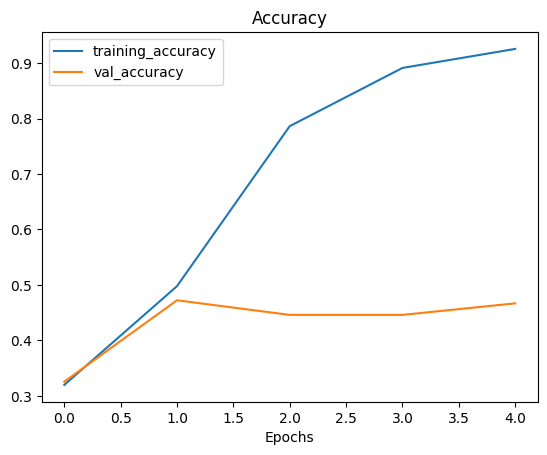

In [30]:
plot_loss_curves(model_history)
plt.show()

In [31]:
# Make predictions on the validation data

model_pred_probs = model.predict(x_test)
model_pred_probs.shape, model_pred_probs[:10]

23/23 [==============================] - 0s 4ms/step


((722, 5),
 array([[2.1943776e-03, 7.6941073e-01, 2.0336021e-02, 1.7987397e-01,
         2.8184880e-02],
        [3.2691839e-01, 4.8647034e-01, 3.6613144e-02, 1.3198850e-01,
         1.8009748e-02],
        [1.5266282e-02, 1.9879603e-01, 6.3207173e-01, 2.7070798e-02,
         1.2679520e-01],
        [1.4508022e-03, 7.7291705e-02, 9.1072375e-01, 1.6248192e-03,
         8.9089777e-03],
        [3.2913948e-03, 5.2392691e-02, 1.5445357e-03, 9.2433399e-01,
         1.8437432e-02],
        [2.1429127e-03, 5.2395903e-02, 9.2942673e-01, 2.1062864e-03,
         1.3928224e-02],
        [1.0005216e-03, 1.9973425e-02, 9.6659541e-01, 1.0066719e-03,
         1.1423972e-02],
        [1.3808816e-02, 9.9551370e-03, 2.2601521e-02, 4.4875417e-02,
         9.0875912e-01],
        [1.2387138e-02, 1.8021984e-01, 7.2187734e-01, 1.3409392e-02,
         7.2106339e-02],
        [7.6094409e-04, 1.1327417e-02, 3.5941676e-04, 9.8146147e-01,
         6.0907612e-03]], dtype=float32))

In [32]:
# Convert prediction probabilities to prediction classes

model_preds = tf.squeeze(tf.round(model_pred_probs))
model_preds[:10]

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)>

In [33]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):

    # Convert one-hot encoded labels to class labels
    y_true_classes = np.argmax(y_true, axis=1) if len(y_true.shape) > 1 else y_true
    y_pred_classes = np.argmax(y_pred, axis=1) if len(y_pred.shape) > 1 else y_pred

    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true_classes, y_pred_classes) * 100
    
    # Calculate model precision, recall, and f1 score using "weighted average"
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [34]:
model_results = calculate_results(y_true=y_test, y_pred=model_preds)
model_results

{'accuracy': 47.50692520775623,
 'precision': 0.4696480281868838,
 'recall': 0.47506925207756234,
 'f1': 0.468950134756359}

Naive Bayes

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_ml = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_ml.fit(X=x_train, 
            y=y_train);

In [38]:
# Evaluate baseline on validation dataset

model_ml.score(X=x_test,
              y=y_test)

0.4362880886426593

In [35]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model("./best_model.LSTM")

# Evaluate the best model on the test data
evaluation_results = best_model.evaluate(x_test, y_test)

# Print the evaluation results
print("Test Accuracy:", evaluation_results[1])
print("Test Loss:", evaluation_results[0])

23/23 [==============================] - 0s 5ms/step - loss: 1.3164 - accuracy: 0.4723
Test Accuracy: 0.47229915857315063
Test Loss: 1.3164407014846802
